### 第6章  与学习相关的技巧

#### 6.1.2  SGD
    
SGD 数学表达式为： $ W \gets  W - \eta \frac {\partial L}{\partial W} $

把需要更新的权重参数记为 W，把损失函数关于 W 的梯度记为 $ \frac {\partial L}{\partial W} $。

$\eta$ 表示学习率，式子中 $\gets$ 表示用右边的值更新左边的值。

In [1]:
# SGD 类
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr # 学习率
    
    def update(self, params, grads):
        # 更新函数。params保存了权重参数，grads保存了梯度。
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### 6.1.3  SGD的缺点

SGD的缺点是，如果函数的形状非均向(anisotropic)，比如呈延伸状，搜索的路径就会非常低效。SGD低效的根本原因是，梯度的方向并没有指向最小值的方向。

#### 6.1.4  Momentum

Momentum是“动能”的意思，和物理有关。用数学式表示Momentum方法如下：

$\quad \quad$ $ \nu \gets \alpha \nu - \eta \frac {\partial L}{\partial W} $ $\quad \quad$ (6.3)

$\quad \quad$ $ W \gets W + \nu $ $\quad \quad$ (6.4)

$\quad \quad$ $ W \gets W + \alpha \nu - \eta \frac{\partial L}{\partial W} $ $\quad \quad$ (6.3 + 6.4)

这里出现了一个变量 $ \nu $，对应物理上的速度

把需要更新的权重参数记为 W，把损失函数关于 W 的梯度记为 $ \frac {\partial L}{\partial W} $。

$\eta$ 表示学习率，式子中 $\gets$ 表示用右边的值更新左边的值。

式(6.3)表示了物体在梯度方向上受力，在这个力的作用下，物体的速度增加这个物理法则。

式(6.3)中有 $\alpha \nu$ 这一项，在物体不受任何力时，该项承担使物体逐渐减速的任务（$\alpha$设定为0.9之类的值），对应物理上的地面摩擦或空气阻力。

In [2]:
import numpy as np

# Momentum SGD的实现
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        # 当第一次调用update()时，v会以字典型变量的形式保存与参数结构相同的数据。
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]
            

#### 6.1.5  AdaGrad

学习率衰减(learning rate decay)：即随着学习的进行，使学习率逐渐减小。实际上，一开始“多”学，然后逐渐“少”学的方法，在神经网络的学习中经常被使用。

AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习。

数学式表示 AdaGrad 的更新方法：

$\quad \quad$ $ h \gets h + \frac {\partial L}{\partial W} \odot \frac {\partial L}{\partial W} $ $\quad \quad$ (6.5)

$\quad \quad$ $ W \gets W - \eta \frac {1}{\sqrt h} \frac {\partial L}{\partial W}$ $\quad \quad$ (6.6)

$\quad \quad$ $ W \gets W - \eta \frac {1}{\sqrt (h + \frac {\partial L}{\partial W} \odot \frac {\partial L}{\partial W})} \frac {\partial L}{\partial W}$ $\quad \quad$ (6.5 + 6.6)

这里出现了一个变量 $ h $，它保存了以前的所有梯度值的平方和 (式(6.5)中的 $ \odot $ 表示对应矩阵元素的乘法)。

在更新参数时，通过乘以 $ \frac {1}{\sqrt h} $ ，就可以调整学习的尺度。这就意味着，参数的元素中变动较大（被大幅更新）的元素的学习率将变小。也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

把需要更新的权重参数记为 W，把损失函数关于 W 的梯度记为 $ \frac {\partial L}{\partial W} $。

$\eta$ 表示学习率，式子中 $\gets$ 表示用右边的值更新左边的值。

AdaGrad 会记录过去所有梯度的平方和。因此，学习越深入，更新的幅度就越小。实际上，如果无止境地学习，更新量就会变成 0 ，完全不再更新。

为了改善这个问题，可以使用 RMSProp 方法。RMSProp 方法并不是将过去所有的梯度一视同仁地相加，而是逐渐地遗忘过去的梯度，在做加法运算时将新梯度的信息更多地反映出来。这种操作从专业上讲，称为“指数移动平均”，呈指数函数式地减小过去的梯度的尺度。

In [5]:
# AdaGrad 实现
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 最后加上 1e-7 ，是为了防止当 self.h[key] 中有0时，将0用作除数的情况。

6.1.6 Adam

Adam 方法，直观地讲，就是融合了Momentum和AdaGrad的方法。通过组合前两个方法的优点，有望实现参数空间的高效搜索，此外，进行超参数的“偏置校正”也是Adam的特征。

Adam 会设置3个超参数。一个是学习率(论文中以 $\alpha$ 出现)，另外两个是一次 momentum 系数 $\beta _1$ 和 二次 momentum 系数 $\beta _2$ 。根据论文，标准的设定值是 $\beta _1$ 为0.9，$\beta _2$ 为0.999。设置了这些值后，大多数情况下都能顺利运行。

In [6]:
# Adam 实现
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


#### 6.1.7 使用哪种更新方法比较好

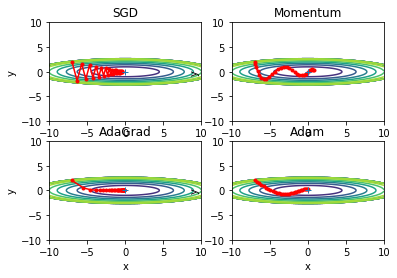

In [9]:
# 对比 SGD、Momentum、AdaGrad、Adam 这4种最优化更新方法
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
# from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, '.-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

#### 6.1.8  基于MNIST数据集的更新方法对比

In [ ]:
# 基于MNIST数据集的4种更新方法的比较：横轴表示学习的迭代次数（Iteration），纵轴表示损失函数的值（loss）
# 这个实验以一个5层神经网络为对象，其中每层有100个神经元。激活函数使用的是 ReLU。

# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


### 6.2  权重的初始值

#### 6.2.2  隐藏层的激活值的分布

简单实验，观察权重初始值是如何影响隐藏层的激活值（激活函数的输出数据）的分布的。

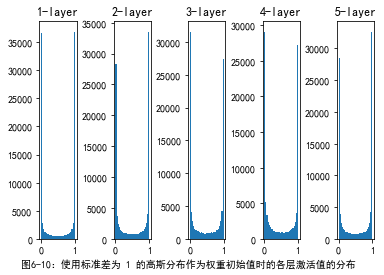

In [75]:
# 实验：向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。
# 使用标准差为 1 的高斯分布作为权重初始值时的各层激活值的分布

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# randn函数返回一个或一组样本，具有标准正态分布。注意randn()与rand()的区别。
x = np.random.randn(1000, 100) # 1000个数据，1000 * 100
node_num = 100 # 各隐藏层的节点（神经元）数
hidden_layer_size = 5 # 隐藏层有5层
activations = {} # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1 # 使用标准差为 1 的高斯分布，实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变化。
    
    z = np.dot(x, w)
    a = sigmoid(z) # sigmoid 函数
    activations[i] = a

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。
    
# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }
plt.xlabel('图6-10：使用标准差为 1 的高斯分布作为权重初始值时的各层激活值的分布',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-10.png', dpi=200)
plt.show()

从图6-10可知，各层的激活值呈偏向0和1分布。这里使用的sigmoid函数是S型函数，随着输出不断地靠近0（或者靠近1），它的导数的值逐渐接近0。因此，偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最后消失。这个问题成为梯度消失（gradient vanishing）。层次加深的深度学习中，梯度消失的问题可能会更加严重。

#### 将权重的标准差设为0.01，进行相同的实验。

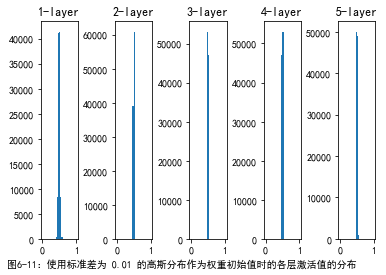

In [76]:
# 实验：向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。
# 使用标准差为 0.01 的高斯分布作为权重初始值时的各层激活值的分布

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# randn函数返回一个或一组样本，具有标准正态分布。注意randn()与rand()的区别。
x = np.random.randn(1000, 100) # 1000个数据，1000 * 100
node_num = 100 # 各隐藏层的节点（神经元）数
hidden_layer_size = 5 # 隐藏层有5层
activations = {} # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01 # 使用标准差为 0.01 的高斯分布，实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变化。
    
    z = np.dot(x, w)
    a = sigmoid(z) # sigmoid 函数
    activations[i] = a

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。
    
# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }
plt.xlabel('图6-11：使用标准差为 0.01 的高斯分布作为权重初始值时的各层激活值的分布',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-11.png', dpi=200)
plt.show()

这次呈集中在0.5附近的分布。激活值的分布有所偏向，说明在表现力上有很大问题。因为如果有多个神经元都输出几乎相同的值，那他们就没有存在的意义了。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

各层的激活值的分布都要求有适当的广度。因为通过在各层间传递多样性的数据，神经网络可以进行高效的学习。反过来，如果传递的是有所偏向的数据，就会出现梯度消失或者“表现力受限”的问题，导致学习可能无法顺利进行。

#### Xavier 权重初始值

在一般的深度学习框架中，Xavier初始值已被作为标准使用。Xavier 的论文中，为了使各层的激活值呈现出具有相同广度的分布，推导出的结论是，如果前一层的节点数为 n ，则初始值使用标准差为 $ \frac {1}{\sqrt n} $ 的分布。

使用Xavier初始值后，前一层的节点数越多，要设定为目标节点的初始值的权重尺度就越小。

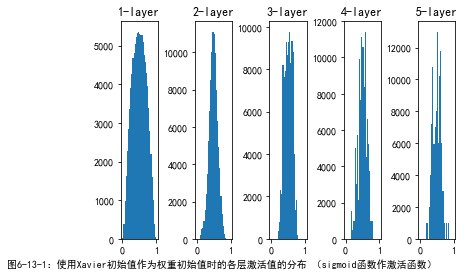

In [80]:
# 实验：向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。
# 使用标准差为 $ \frac {1}{\sqrt n} $ 的高斯分布作为权重初始值时的各层激活值的分布
# 使用Xavier初始值作为权重初始值时的各层激活值的分布

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# randn函数返回一个或一组样本，具有标准正态分布。注意randn()与rand()的区别。
x = np.random.randn(1000, 100) # 1000个数据，1000 * 100
node_num = 100 # 各隐藏层的节点（神经元）数
hidden_layer_size = 5 # 隐藏层有5层
activations = {} # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 使用标准差为 Xavier初始值的 $ \frac {1}{\sqrt n} $ 的高斯分布，实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变化。
    
    z = np.dot(x, w)
    a = sigmoid(z) # sigmoid 函数
    activations[i] = a

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。
    
# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }
plt.xlabel('图6-13-1：使用Xavier初始值作为权重初始值时的各层激活值的分布 （sigmoid函数作激活函数）',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-13-1.png', dpi=200)
plt.show()

使用Xavier初始值后的结果如图6-13所示。从这个结果可知，越是后面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。

如果用 tanh 函数（双曲线函数）替代 sigmoid 函数，这个稍微歪斜的问题就能得到改善。tanh 函数时关于原点(0,0)对称的S型曲线，而 sigmoid 函数时关于 (x,y)=(0,0.5) 对称的S型曲线。众所周知，用作激活函数的函数最好具有关于原点对称的性质。

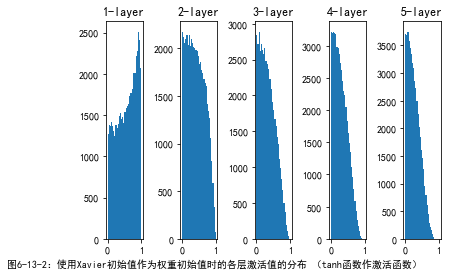

In [81]:
# 实验：向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。
# 使用标准差为 $ \frac {1}{\sqrt n} $ 的高斯分布作为权重初始值时的各层激活值的分布
# 使用Xavier初始值作为权重初始值时的各层激活值的分布
# 激活函数改为关于原点对称的S型曲线的 tanh 函数

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# randn函数返回一个或一组样本，具有标准正态分布。注意randn()与rand()的区别。
x = np.random.randn(1000, 100) # 1000个数据，1000 * 100
node_num = 100 # 各隐藏层的节点（神经元）数
hidden_layer_size = 5 # 隐藏层有5层
activations = {} # 激活值的结果保存在这里

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 使用标准差为 Xavier初始值的 $ \frac {1}{\sqrt n} $ 的高斯分布，实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变化。
    
    z = np.dot(x, w)
#   a = sigmoid(z) # sigmoid 函数
    a = tanh(z) # tanh 函数
    activations[i] = a

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。
    
# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }
plt.xlabel('图6-13-2：使用Xavier初始值作为权重初始值时的各层激活值的分布 （tanh函数作激活函数）',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-13-2.png', dpi=200)
plt.show()

6.2.3  ReLU 的权重初始值

sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适合使用 Xavier初始值。

但当激活函数使用ReLU时，一般推荐使用ReLU专用的初始值，也就是Kaiming He等人推荐的初始值，也称为“He初始值”。当前一层的节点数为n时，He初始值使用标准差为 $ \sqrt \frac {2}{n}  $ 的高斯分布。

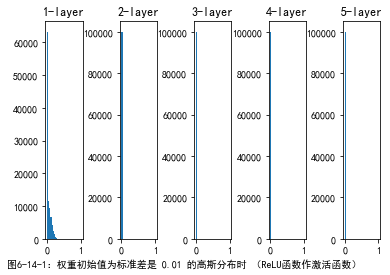

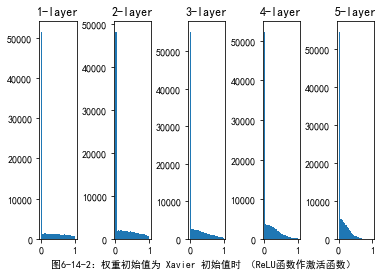

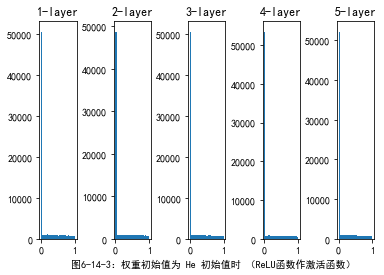

In [107]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里
activations['0'] = {}
activations['1'] = {}
activations['2'] = {}

x = input_data

for i in range(hidden_layer_size):
    
    # 权重初始值为标准差是 0.01 的高斯分布时 （ReLU函数作激活函数）
    if i != 0:
        x = activations['0'][i-1]
    w = np.random.randn(node_num, node_num) * 0.01 # 初始值为标准差0.01
    a = np.dot(x, w)
    z = ReLU(a)
    activations['0'][i] = z

    # 权重初始值为 Xavier 初始值时 （ReLU函数作激活函数）
    if i != 0:
        x = activations['1'][i-1]
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # 初始值为 Xavier 初始值
    a = np.dot(x, w)
    z = ReLU(a)
    activations['1'][i] = z

    # 权重初始值为 He 初始值时 （ReLU函数作激活函数）
    if i != 0:
        x = activations['2'][i-1]
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # 初始值为 ReLU 专用的“He初始值”
    a = np.dot(x, w)
    z = ReLU(a)
    activations['2'][i] = z


# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }

# 绘制直方图 - 1
for i, a in activations['0'].items():
    plt.subplot(1, len(activations['0']), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。
    
plt.xlabel('图6-14-1：权重初始值为标准差是 0.01 的高斯分布时 （ReLU函数作激活函数）',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-14-1.png', dpi=200)
plt.show()

# 绘制直方图 - 2
for i, a in activations['1'].items():
    plt.subplot(1, len(activations['1']), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。

plt.xlabel('图6-14-2：权重初始值为 Xavier 初始值时 （ReLU函数作激活函数）',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-14-2.png', dpi=200)
plt.show()

# 绘制直方图 - 3
for i, a in activations['2'].items():
    plt.subplot(1, len(activations['2']), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), bins=30, range=(0,1)) # flatten(),返回一个折叠成一维的数组。

plt.xlabel('图6-14-3：权重初始值为 He 初始值时 （ReLU函数作激活函数）',override)
plt.subplots_adjust(wspace=1)
plt.savefig('fig6-14-3.png', dpi=200)
plt.show()

总结一下，当激活函数使用ReLU时，权重初始值使用He初始值，当激活函数为sigmoid或者tanh等S型曲线函数时，初始值使用Xavier初始值，这是目前的最佳实践。

#### 6.2.4  基于MNIST数据集的权重初始值的比较

通过实际数据，观察不同的权重初始值的赋值方法会在多大程度上影响神经网络的学习。这里我们基于 std=0.01、Xavier初始值、He初始值进行实验。

In [ ]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

该实验中，神经网络有5层，每层有100个神经元，激活函数使用的是ReLU。实验结果可知，std=0.01完全无法进行学习；当权重初始值为Xavier初始值和He初始值时，学习进行得很顺利，并且，He初始值的学习进度更快一点。

#### 6.3  Batch Normalization

#### 6.3.1  Batch Normalization 的算法

1、可以使学习快速进行（可以增大学习率）

2、不那么依赖初始值（对于初始值不用那么神经质）

3、抑制过拟合（降低Dropout等的必要性）

如前所述，Batch Norm的思路是调整各层的激活值分布使其拥有适当的广度。为此，要向神经网络中插入对数据分布进行正规化的层，即Batch Normalization层（下文简称Batch Norm层）。

Batch Noem，顾名思义，以进行学习时的mini-batch为单位，按mini-batch进行正规化。具体而言，就是进行使数据分析的均值为0、方差为1的正规化。用数学式表示如下：

$\quad \quad$ $ \mu_B \gets \frac {1}{m} \sum_{i=0}^m x_i $

$\quad \quad$ $ \sigma_B^2 \gets \frac {1}{m} \sum_{i=0}^m (x_i - \mu_B)^2 $

$\quad \quad$ $ \widehat{x_i} \gets \frac {x_i - \mu_B}{\sqrt(\sigma_B^2 + \varepsilon)} $ $\quad \quad \quad \quad$  (6.7)

这里对mini-batch的m个输入数据的集He $ B = {x_1,x_2, ... ,x_m)} $ 求均值$ \mu_B $ 和方差$ \sigma_B^2 $。然后，对输入数据进行均值为0、方差为1（合适的分布）的正规化。式子中的 $\varepsilon$ 是一个微小值（比如，10e-7等），它是为了防止出现除以0的情况。

接着，Batch Norm层会对正规化后的数据进行缩放和平移变换，用数学式表示如下：

$ \quad \quad $ $ y_i \gets \gamma \widehat{x_i} + \beta $

这里 $ \gamma $ 和 $ \beta $ 是参数。一开始 $ \gamma = 1 $ ， $ \beta = 0 $，然后再通过学习调整到合适的值。

#### 6.3.2  Batch Normalization的评估

几乎所有的情况下都是使用Batch Norm时学习进行得更快。因此，通过使用Batch Norm，可以推动学习的进行。并且，对权重初始值变得健壮（“对初始值健壮”表示不那么依赖初始值）。

============== 1/16 ==============
epoch:0 | 0.117 - 0.104
epoch:1 | 0.097 - 0.101
epoch:2 | 0.097 - 0.106
epoch:3 | 0.097 - 0.131
epoch:4 | 0.097 - 0.153
epoch:5 | 0.097 - 0.177
epoch:6 | 0.097 - 0.186
epoch:7 | 0.097 - 0.218
epoch:8 | 0.097 - 0.241
epoch:9 | 0.097 - 0.274
epoch:10 | 0.097 - 0.289
epoch:11 | 0.097 - 0.303
epoch:12 | 0.097 - 0.315
epoch:13 | 0.097 - 0.337
epoch:14 | 0.097 - 0.349
epoch:15 | 0.097 - 0.366
epoch:16 | 0.097 - 0.382
epoch:17 | 0.097 - 0.4
epoch:18 | 0.097 - 0.408
epoch:19 | 0.097 - 0.422
============== 2/16 ==============
epoch:0 | 0.117 - 0.09
epoch:1 | 0.097 - 0.065
epoch:2 | 0.097 - 0.096
epoch:3 | 0.097 - 0.141
epoch:4 | 0.097 - 0.169
epoch:5 | 0.097 - 0.18
epoch:6 | 0.097 - 0.209
epoch:7 | 0.097 - 0.245
epoch:8 | 0.097 - 0.266
epoch:9 | 0.097 - 0.281
epoch:10 | 0.097 - 0.313
epoch:11 | 0.097 - 0.336
epoch:12 | 0.097 - 0.35
epoch:13 | 0.097 - 0.37
epoch:14 | 0.097 - 0.39
epoch:15 | 0.097 - 0.414
epoch:16 | 0.097 - 0.431
epoch:17 | 0.097 - 0.455
epoch:1

epoch:14 | 0.116 - 0.419
epoch:15 | 0.117 - 0.42
epoch:16 | 0.116 - 0.42
epoch:17 | 0.117 - 0.42
epoch:18 | 0.116 - 0.42
epoch:19 | 0.117 - 0.42


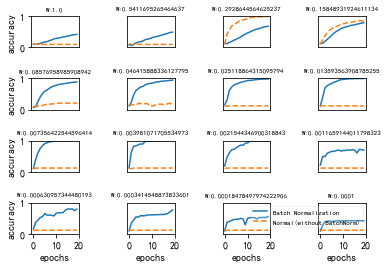

In [119]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 减少学习数据
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

# 3.绘制图形==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w), fontsize='x-small')
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")

plt.legend(loc='best', fontsize='x-small',framealpha=0.2)
plt.subplots_adjust(wspace=1, hspace=1)
plt.savefig('fig6-19.png', dpi=400)
plt.show()

#### 6.4 正则化

过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。因此，抑制过拟合的技巧也很重要。

#### 6.4.1  过拟合

过拟合的原因：1)模型拥有大量参数、表现力强。2)训练数据少。

epoch:0, train acc:0.1, test acc:0.0963
epoch:1, train acc:0.1, test acc:0.098
epoch:2, train acc:0.12, test acc:0.1059
epoch:3, train acc:0.14333333333333334, test acc:0.1175
epoch:4, train acc:0.14666666666666667, test acc:0.123
epoch:5, train acc:0.18, test acc:0.1364
epoch:6, train acc:0.22666666666666666, test acc:0.1539
epoch:7, train acc:0.24333333333333335, test acc:0.1635
epoch:8, train acc:0.29, test acc:0.1941
epoch:9, train acc:0.3233333333333333, test acc:0.2068
epoch:10, train acc:0.37333333333333335, test acc:0.2325
epoch:11, train acc:0.39, test acc:0.2545
epoch:12, train acc:0.42333333333333334, test acc:0.2805
epoch:13, train acc:0.43333333333333335, test acc:0.2879
epoch:14, train acc:0.4533333333333333, test acc:0.3072
epoch:15, train acc:0.47333333333333333, test acc:0.3254
epoch:16, train acc:0.4633333333333333, test acc:0.3322
epoch:17, train acc:0.49666666666666665, test acc:0.361
epoch:18, train acc:0.5166666666666667, test acc:0.3811
epoch:19, train acc:0.5466

epoch:161, train acc:1.0, test acc:0.7541
epoch:162, train acc:1.0, test acc:0.755
epoch:163, train acc:1.0, test acc:0.7545
epoch:164, train acc:1.0, test acc:0.7537
epoch:165, train acc:1.0, test acc:0.7558
epoch:166, train acc:1.0, test acc:0.7563
epoch:167, train acc:1.0, test acc:0.7569
epoch:168, train acc:1.0, test acc:0.7589
epoch:169, train acc:1.0, test acc:0.7576
epoch:170, train acc:1.0, test acc:0.7566
epoch:171, train acc:1.0, test acc:0.7583
epoch:172, train acc:1.0, test acc:0.7565
epoch:173, train acc:1.0, test acc:0.7574
epoch:174, train acc:1.0, test acc:0.759
epoch:175, train acc:1.0, test acc:0.7562
epoch:176, train acc:1.0, test acc:0.756
epoch:177, train acc:1.0, test acc:0.7557
epoch:178, train acc:1.0, test acc:0.7554
epoch:179, train acc:1.0, test acc:0.7544
epoch:180, train acc:1.0, test acc:0.7561
epoch:181, train acc:1.0, test acc:0.7553
epoch:182, train acc:1.0, test acc:0.7572
epoch:183, train acc:1.0, test acc:0.755
epoch:184, train acc:1.0, test acc:0.7

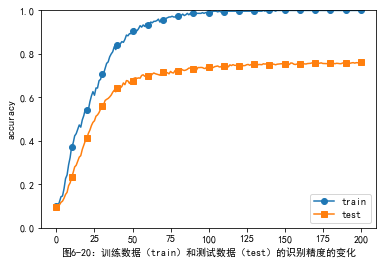

In [125]:
# 从MNIST数据集原本的60000个训练数据中只选定300个，并且，为了增加网络的复杂度，使用7层网络（每层有100个神经元，激活函数为ReLU）

# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train),(x_test,t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
weight_decay_lambda = 0 # 不使用权值衰减的情况
# weight_decay_lambda = 0.1 # 使用权值衰减的情况
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # SGD随机梯度下降，学习率为0.01

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loos_list = [] # 训练损失
train_acc_list = [] # 训练正确率
test_acc_list = [] # 测试正确率

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 3.绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.xlabel('图6-20：训练数据（train）和测试数据（test）的识别精度的变化')
plt.savefig('fig6-20.png', dpi=200)
plt.show()

过来100个epoch左右后，测试数据测量到的识别精度与训练数据测量到的识别精度存在较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。

#### 6.4.2  权值衰减

权值衰减是一直以来经常被使用的一种抑制过拟合的方法。该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合原本就是因为权重参数取值过大才发生的。可以通过为损失函数加上权重的平方范数（L2范数），就可以抑制权重变大。

用符号表示，如果将权重记为$ W $，L2范数的权值衰减就是$ \frac{1}{2} \lambda W^2 $，然后将这个$ \frac{1}{2} \lambda W^2 $加到损失函数上。这里，$ \lambda $是控制正则化强度的超参数，$ \lambda $设置得越大，对大的权重施加的惩罚就越重。此外，$ \frac{1}{2} \lambda W^2 $开头的$\frac{1}{2}$是用于将$ \frac{1}{2} \lambda W^2 $的求导结果变成$ \lambda W $的调整用敞亮。

对于所有权重，权值衰减方法都会为损失函数加上$ \frac{1}{2} \lambda W^2 $。因此，在求权重梯度的计算中，要为之前的误差反向传播法的结果加上正则化的导数$\lambda W$。

epoch:0, train acc:0.09333333333333334, test acc:0.0859
epoch:1, train acc:0.12, test acc:0.0893
epoch:2, train acc:0.11333333333333333, test acc:0.0969
epoch:3, train acc:0.13666666666666666, test acc:0.1042
epoch:4, train acc:0.16333333333333333, test acc:0.1127
epoch:5, train acc:0.17, test acc:0.123
epoch:6, train acc:0.19333333333333333, test acc:0.1362
epoch:7, train acc:0.21666666666666667, test acc:0.1536
epoch:8, train acc:0.26, test acc:0.1848
epoch:9, train acc:0.2833333333333333, test acc:0.2014
epoch:10, train acc:0.32, test acc:0.2194
epoch:11, train acc:0.36333333333333334, test acc:0.245
epoch:12, train acc:0.37, test acc:0.2615
epoch:13, train acc:0.4, test acc:0.2785
epoch:14, train acc:0.43333333333333335, test acc:0.3033
epoch:15, train acc:0.47333333333333333, test acc:0.3237
epoch:16, train acc:0.45666666666666667, test acc:0.3291
epoch:17, train acc:0.47333333333333333, test acc:0.3445
epoch:18, train acc:0.4766666666666667, test acc:0.3596
epoch:19, train acc:0.

epoch:161, train acc:0.9033333333333333, test acc:0.6993
epoch:162, train acc:0.9066666666666666, test acc:0.7027
epoch:163, train acc:0.89, test acc:0.6991
epoch:164, train acc:0.8866666666666667, test acc:0.6966
epoch:165, train acc:0.8966666666666666, test acc:0.6982
epoch:166, train acc:0.89, test acc:0.6956
epoch:167, train acc:0.8966666666666666, test acc:0.6948
epoch:168, train acc:0.8933333333333333, test acc:0.6925
epoch:169, train acc:0.9066666666666666, test acc:0.7046
epoch:170, train acc:0.8933333333333333, test acc:0.6991
epoch:171, train acc:0.8933333333333333, test acc:0.702
epoch:172, train acc:0.91, test acc:0.7061
epoch:173, train acc:0.9, test acc:0.7008
epoch:174, train acc:0.92, test acc:0.7041
epoch:175, train acc:0.8966666666666666, test acc:0.7062
epoch:176, train acc:0.8933333333333333, test acc:0.7007
epoch:177, train acc:0.9033333333333333, test acc:0.7069
epoch:178, train acc:0.91, test acc:0.7013
epoch:179, train acc:0.9033333333333333, test acc:0.7019
epo

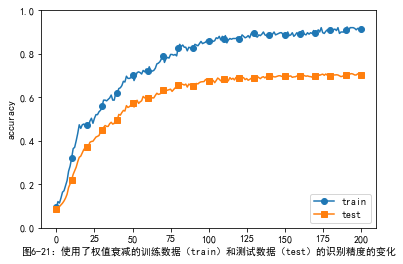

In [127]:
# 从MNIST数据集原本的60000个训练数据中只选定300个，并且，为了增加网络的复杂度，使用7层网络（每层有100个神经元，激活函数为ReLU）

# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train),(x_test,t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
# weight_decay_lambda = 0 # 不使用权值衰减的情况
weight_decay_lambda = 0.1 # 使用权值衰减的情况
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # SGD随机梯度下降，学习率为0.01

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loos_list = [] # 训练损失
train_acc_list = [] # 训练正确率
test_acc_list = [] # 测试正确率

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 3.绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.xlabel('图6-21：使用了权值衰减的训练数据（train）和测试数据（test）的识别精度的变化')
plt.savefig('fig6-21.png', dpi=200)
plt.show()

与未使用权值衰减的图6-20的结果相比，差距变小了，这说明了过拟合受到了抑制。

#### 6.4.3  Dropout

如果网络的模型变得很复杂，只用权值衰减就难以应对了。在这种情况下，我们经常会使用Dropout方法。

Dropout是一种在学习的过程中随机删除神经元的方法。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递。

训练时，每传递一次数据，就会随机选择要删除的神经元。然后，测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出，要乘上训练时的删除比例后再输出。

In [129]:
# Dropout 实现
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask
    

这里的要点是，每次正向传播时，self.mask中都会以False的形式保存要删除的神经元。self.mask会随机生成和x形状相同的数据，并将值比dropout_ratio大的元素设为True。反向传播时的行为和ReLU相同。也就是说，正向传播时传递了信号的神经元，反向传播时按原样传递信号；正向传播时，没有传递信号的神经元，反向传播时信号将停在那里。

train loss:2.300552868591968
=== epoch:1, train acc:0.09666666666666666, test acc:0.1083 ===
train loss:2.3271036092435766
train loss:2.29500200680932
train loss:2.31904136222233
=== epoch:2, train acc:0.09666666666666666, test acc:0.1137 ===
train loss:2.3170812250854853
train loss:2.3227207964971597
train loss:2.301140039992503
=== epoch:3, train acc:0.10666666666666667, test acc:0.1196 ===
train loss:2.2889573580721074
train loss:2.307041642017931
train loss:2.2842059631094975
=== epoch:4, train acc:0.10666666666666667, test acc:0.1264 ===
train loss:2.287354090627706
train loss:2.3034841801871777
train loss:2.317092262183642
=== epoch:5, train acc:0.10666666666666667, test acc:0.1335 ===
train loss:2.319904860718444
train loss:2.280126282065579
train loss:2.292075996037235
=== epoch:6, train acc:0.11666666666666667, test acc:0.1384 ===
train loss:2.2920783609369892
train loss:2.312572756876064
train loss:2.3172788240599793
=== epoch:7, train acc:0.12333333333333334, test acc:0.1448

=== epoch:56, train acc:0.36666666666666664, test acc:0.2904 ===
train loss:2.219908674544619
train loss:2.2389308135191834
train loss:2.210397268284843
=== epoch:57, train acc:0.36333333333333334, test acc:0.2906 ===
train loss:2.2310187090304385
train loss:2.2205854829163347
train loss:2.2206917416532233
=== epoch:58, train acc:0.36, test acc:0.2897 ===
train loss:2.212226331813953
train loss:2.2203784607158714
train loss:2.207324833284644
=== epoch:59, train acc:0.3566666666666667, test acc:0.2884 ===
train loss:2.194941215639279
train loss:2.223279517165995
train loss:2.215756248086346
=== epoch:60, train acc:0.35333333333333333, test acc:0.2892 ===
train loss:2.2194904448400425
train loss:2.231066274863116
train loss:2.2172927663382556
=== epoch:61, train acc:0.36, test acc:0.2924 ===
train loss:2.2162711079890367
train loss:2.201641157812802
train loss:2.2126879030628896
=== epoch:62, train acc:0.36, test acc:0.2913 ===
train loss:2.2036072782252925
train loss:2.218641040526187
t

=== epoch:112, train acc:0.43333333333333335, test acc:0.336 ===
train loss:2.0763587270229937
train loss:2.000881539906919
train loss:2.0164430652980276
=== epoch:113, train acc:0.44, test acc:0.3367 ===
train loss:2.082314136081847
train loss:2.0285152101046133
train loss:2.0245455983055365
=== epoch:114, train acc:0.44, test acc:0.3375 ===
train loss:2.006191398903749
train loss:2.042055345719173
train loss:2.045212326751064
=== epoch:115, train acc:0.43666666666666665, test acc:0.3387 ===
train loss:2.0192145294716655
train loss:2.0750880220270425
train loss:2.0266952519701835
=== epoch:116, train acc:0.44, test acc:0.3383 ===
train loss:1.9876612123939714
train loss:2.0811151663562355
train loss:1.9257758816801727
=== epoch:117, train acc:0.44333333333333336, test acc:0.342 ===
train loss:1.9928676824915763
train loss:2.023577752736168
train loss:1.9449333296855307
=== epoch:118, train acc:0.44, test acc:0.3381 ===
train loss:2.046387349725814
train loss:2.0120112898166598
train l

=== epoch:167, train acc:0.4766666666666667, test acc:0.3836 ===
train loss:1.7480773213270624
train loss:1.789685890614459
train loss:1.659671238233675
=== epoch:168, train acc:0.4866666666666667, test acc:0.3843 ===
train loss:1.667922448786576
train loss:1.8070707690535304
train loss:1.6790348301894582
=== epoch:169, train acc:0.49333333333333335, test acc:0.3898 ===
train loss:1.8200770513315658
train loss:1.741727458556041
train loss:1.7492903770719044
=== epoch:170, train acc:0.49666666666666665, test acc:0.398 ===
train loss:1.6455945431104424
train loss:1.8309465123666087
train loss:1.7219332588648144
=== epoch:171, train acc:0.5033333333333333, test acc:0.4005 ===
train loss:1.8316634622616947
train loss:1.726609200395159
train loss:1.720666648889648
=== epoch:172, train acc:0.5033333333333333, test acc:0.4009 ===
train loss:1.8306083534777742
train loss:1.7184610979346464
train loss:1.7292184417297676
=== epoch:173, train acc:0.5133333333333333, test acc:0.403 ===
train loss:

=== epoch:222, train acc:0.5466666666666666, test acc:0.4498 ===
train loss:1.4113548971154355
train loss:1.4955337989137252
train loss:1.3658546065565775
=== epoch:223, train acc:0.5466666666666666, test acc:0.4494 ===
train loss:1.546422159489495
train loss:1.1950143640205697
train loss:1.369643402983303
=== epoch:224, train acc:0.5366666666666666, test acc:0.4463 ===
train loss:1.5528023508623547
train loss:1.4805766329192631
train loss:1.3370052646621422
=== epoch:225, train acc:0.54, test acc:0.449 ===
train loss:1.5262120884989798
train loss:1.1728009799769314
train loss:1.4315620270586522
=== epoch:226, train acc:0.5433333333333333, test acc:0.4508 ===
train loss:1.2778941121108747
train loss:1.3545054703063517
train loss:1.4243585909171423
=== epoch:227, train acc:0.5433333333333333, test acc:0.4474 ===
train loss:1.4465107709195437
train loss:1.396708976724267
train loss:1.5027994718399875
=== epoch:228, train acc:0.5466666666666666, test acc:0.4511 ===
train loss:1.4718106001

=== epoch:277, train acc:0.5833333333333334, test acc:0.4927 ===
train loss:1.1453001899827955
train loss:1.2322545477589077
train loss:1.2297404512914574
=== epoch:278, train acc:0.6, test acc:0.4958 ===
train loss:1.1453178688034895
train loss:1.218937800665134
train loss:1.2012234882505561
=== epoch:279, train acc:0.6033333333333334, test acc:0.496 ===
train loss:1.1186840731141414
train loss:1.1730759086781188
train loss:1.2072110377942327
=== epoch:280, train acc:0.6, test acc:0.4962 ===
train loss:1.0130294435721605
train loss:1.108627089347966
train loss:1.1334882932766663
=== epoch:281, train acc:0.6, test acc:0.4986 ===
train loss:1.1270561794616136
train loss:1.1602816771704152
train loss:1.0376016250148816
=== epoch:282, train acc:0.6, test acc:0.4998 ===
train loss:1.1885655265180126
train loss:1.00317266759046
train loss:1.1025075067424333
=== epoch:283, train acc:0.6, test acc:0.4982 ===
train loss:1.1114051591621157
train loss:1.1729651290219456
train loss:0.990818449615

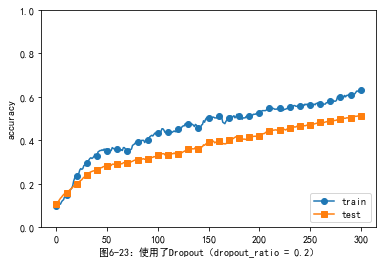

In [131]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# 设定是否使用Dropuout，以及比例 ========================
use_dropout = True  # 不使用Dropout的情况下为False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.xlabel('图6-23：使用了Dropout（dropout_ratio = 0.2）')
plt.savefig('fig6-23.png', dpi=200)
plt.show()

#### 6.5 超参数的验证

超参数是指，比如各层的神经元数量、batch大小、参数更新时的学习率或权值衰减等。

调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为验证数据（validation data）。

训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性能评估。为了确认泛华能力，要在最后使用（比较理想的是只用一次）测试数据。

In [137]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

# 从训练数据中事先分割20%作为验证数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train) # 打乱训练数据，shuffle_dataset函数利用了np.random.shuffle
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

#### 6.5.2  超参数的最优化

进行超参数的优化时，逐渐缩小超参数的“好值”的存在范围非常重要。超参数的范围只要“大致地指定”就可以了。

#### 6.5.3  超参数最优化的实现

这里我们将学习率和控制权值衰减强度的系数这两个超参数的搜索问题作为对象。

val acc:0.18 | lr:3.813169646420258e-05, weight decay:2.2060775646761714e-06
val acc:0.09 | lr:0.00013293456642606656, weight decay:1.1162899412651702e-05
val acc:0.23 | lr:0.0008918998234413113, weight decay:3.998404651495896e-06
val acc:0.06 | lr:2.4850541903125997e-05, weight decay:1.7639866594222367e-07
val acc:0.07 | lr:3.983003875544535e-06, weight decay:8.443265575241384e-05
val acc:0.11 | lr:9.36086532319118e-06, weight decay:1.204249623581314e-05
val acc:0.16 | lr:3.913272507116487e-05, weight decay:6.898455982459856e-07
val acc:0.34 | lr:0.0020441275216701873, weight decay:3.7334796686681217e-06
val acc:0.07 | lr:1.5348545442001395e-06, weight decay:1.140349421700766e-08
val acc:0.53 | lr:0.003680919704704405, weight decay:1.0461048002829408e-08
val acc:0.06 | lr:3.731968247453427e-06, weight decay:2.705578281519817e-08
val acc:0.06 | lr:3.190616418176857e-06, weight decay:1.1696280251022496e-08
val acc:0.05 | lr:6.318921373472454e-06, weight decay:1.3369914155110563e-08
val 

Best-7(val acc:0.74) | lr:0.007838758480612846, weight decay:1.1613445369311995e-05
Best-8(val acc:0.72) | lr:0.004781626929422883, weight decay:2.433915984464949e-07
Best-9(val acc:0.72) | lr:0.007486586973411034, weight decay:9.1461528356198e-08
Best-10(val acc:0.72) | lr:0.004446120560345803, weight decay:1.0028787868384014e-07
Best-11(val acc:0.59) | lr:0.0038724260273898976, weight decay:1.600883599324887e-05
Best-12(val acc:0.59) | lr:0.0042602667764854284, weight decay:1.8692961916645874e-05
Best-13(val acc:0.53) | lr:0.003680919704704405, weight decay:1.0461048002829408e-08
Best-14(val acc:0.5) | lr:0.0026350285889033746, weight decay:1.0467223346971982e-07
Best-15(val acc:0.44) | lr:0.003323496230045214, weight decay:2.987803288971286e-08
Best-16(val acc:0.44) | lr:0.0010417567975290472, weight decay:3.935813090895522e-06
Best-17(val acc:0.44) | lr:0.002095796709970967, weight decay:1.0398817039801696e-06
Best-18(val acc:0.39) | lr:0.0017491448898263634, weight decay:1.2632099

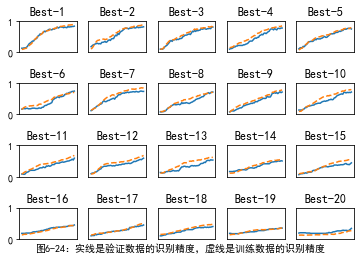

In [140]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

# 设置横纵坐标的对应字体格式
override = {
    'fontsize'            : '10', # 字体大小：10
    'verticalalignment'   : 'top', # 垂直对齐：top
    'horizontalalignment' : 'right' # 水平对齐：right
    }
plt.subplots_adjust(hspace=1)
plt.xlabel('图6-24：实线是验证数据的识别精度，虚线是训练数据的识别精度', override)
plt.savefig('fig6-24.png', dpi=200)
plt.show()
